In [1]:
import os
import sys
import numpy as np
from tqdm import tqdm

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import models, transforms

In [26]:
sys.path.append('..')  # 添加上级目录到搜索路径

from utils.layer_utils import GradCAM, show_cam_on_image  # LayerCam & WeightCam替换一下utils文件

In [39]:
def cnn_cam(data_path, num_classes):
    model = models.resnet34()
    in_channel = model.fc.in_features
    model.fc = torch.nn.Linear(in_channel, num_classes)
    model.load_state_dict(torch.load('/home/ubuntu/workspace/hy/grad_cam/train_model/resnet/resNet34-dagm-1026.pth', map_location='cpu'))
    

    target_layers_4 = [model.layer4]
    cam(model, target_layers_4, data_path, "4")

    target_layers_3 = [model.layer3]
    cam(model, target_layers_3, data_path, "3")

    target_layers_2 = [model.layer2]
    cam(model, target_layers_2, data_path, "2")
    
    # target_layers = [model.layer1]    
    # cam(model, target_layers_1, data_path)



def cam(model, target_layers, data_path, suffix=""):
    data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)
    
    cls_folder_path = data_path

    target_category = 0

    
    for img_file in tqdm(os.listdir(cls_folder_path), desc="Processing: "):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
        img_path = os.path.join(cls_folder_path, img_file)
        # load image
        assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img, dtype=np.uint8)

        # 原图
        axs[0].imshow(img)
        axs[0].set_title('Origin')
        axs[0].axis('off')

        # [C, H, W]
        img_tensor = data_transform(img)
        # [C, H, W] -> [N, C, H, W]
        input_tensor = torch.unsqueeze(img_tensor, dim=0)
        grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                        grayscale_cam,
                                        use_rgb=True)
        axs[1].imshow(visualization)
        axs[1].set_title('Visualization')
        axs[1].axis('off')

        
        grayscale_cam_8bit = (grayscale_cam * 255).astype('uint8')
        
        # 设置每个类别的分割阈值
        _, thresh = cv2.threshold(grayscale_cam_8bit, 127, 255, cv2.THRESH_BINARY)
        
        # 画出预测框
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            area = w * h
            # 忽略面积小于64的预测框
            if area >= 64:
                cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
        axs[2].imshow(img)
        axs[2].set_title('Bbox')
        axs[2].axis('off')

        res_path = os.path.join('./layers/', img_file.split('.')[0])
        os.makedirs(res_path, exist_ok=True)
        plt.savefig(os.path.join(res_path, suffix + '.png'))
        
        break

Processing:   0%|                                                                                                                                                                                                                                      | 0/50 [00:00<?, ?it/s]


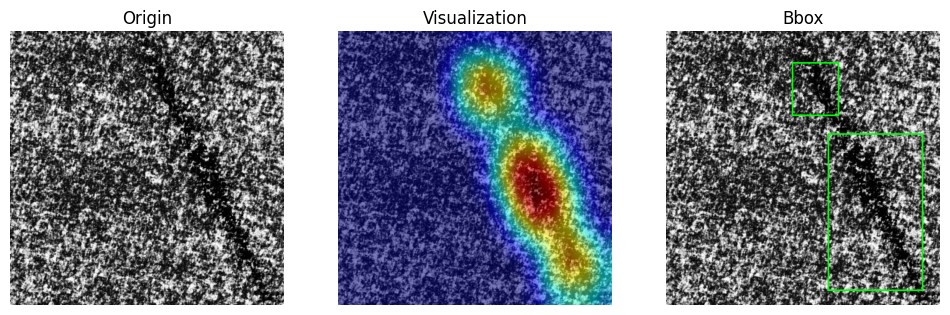

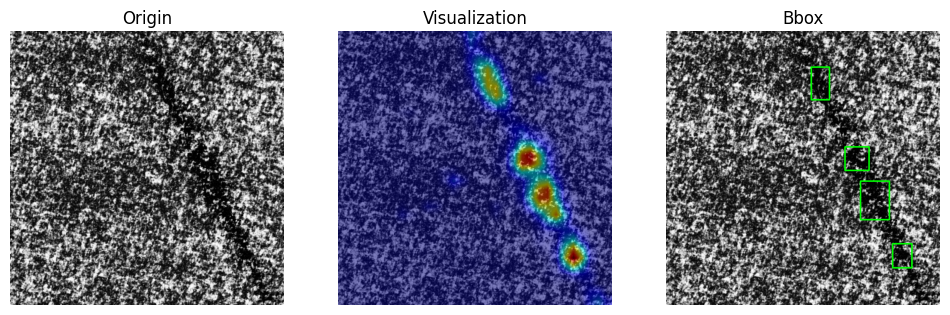

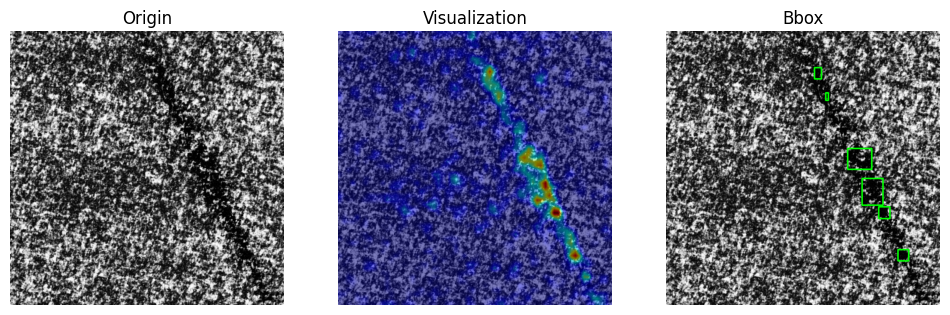

In [40]:
cnn_cam(data_path='/home/ubuntu/workspace/hy/dataset/DAGM/best/',
        num_classes=2)